## Prepare data

### Only consider remove outliers

Read all the data. Apply simple outlier removal by validity range.

In [5]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd


def pre_processing(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

### Apply smoothing as a preprocessing

It can be seen that we have quite a lot of noise in the data, especitally on the voltage. Let's apply a sliding window smoothing to the remove the potential noise.

In [6]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt


# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  # Assuming your data is evenly spaced in time


def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    # df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    # df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # Make sure that the difference between the current and previous temperature cannot be too large.
    # Define your threshold
    threshold = 10
    # Shift the 'temperature' column by one row to get the previous temperature
    prev_tmp = df['temperature'].shift(1)
    # Calculate the absolute difference between current and previous temperature
    temp_diff = np.abs(df['temperature'] - prev_tmp)
    # Set the temperature to NaN where the difference is larger than the threshold
    df.loc[temp_diff > threshold, 'temperature'] = np.nan
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    # df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    # df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()
    

from utility import read_all_csvs_one_test
import matplotlib.pyplot as plt
import pandas as pd
import os

# Get all the folders in the base_dictionary
path_list = os.listdir(base_dictionary)
# Only keep the folders, not the excel file.
path_list = path_list[:-1]

# Read the data.
df_data_smoothing = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    # Read the data with the customized outlier removal function.
    tmp_df = read_all_csvs_one_test(path, tmp_path, customized_outlier_removal)
    df_data_smoothing = pd.concat([df_data_smoothing, tmp_df])
    df_data_smoothing = df_data_smoothing.reset_index(drop=True)

# Read the test conditions
df_test_conditions = pd.read_excel(base_dictionary+'Test conditions.xlsx')

# Visulize the data
# for selected_sequence_idx in path_list:
#     filtered_df = df_data_smoothing[df_data_smoothing['test_condition'] == selected_sequence_idx]

#     print('{}: {}\n'.format(selected_sequence_idx, df_test_conditions[df_test_conditions['Test id'] == selected_sequence_idx]['Description']))

#     fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
#     for ax, col in zip(axes.flat, ['data_motor_1_position', 'data_motor_2_position', 'data_motor_3_position', 
#         'data_motor_1_temperature', 'data_motor_2_temperature', 'data_motor_3_temperature',
#         'data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage']):
#         ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
#         ax.set_ylabel(col)

#     fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
#     for ax, col in zip(axes.flat, ['data_motor_4_position', 'data_motor_5_position', 'data_motor_6_position',
#         'data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_6_temperature',
#         'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']):
#         ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
#         ax.set_ylabel(col)

#     plt.show()

## Define experiment supporting function

### Training the model for all motors, using all the features.

In the regression-based approach, we only need normal samples to learn the normal patterns.

In [7]:
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']
df_data = df_data[df_data['test_condition'].isin(normal_test_id)]
df_data_smoothing = df_data_smoothing[df_data_smoothing['test_condition'].isin(normal_test_id)]


### We define a linear regression model.

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge, Lasso,LogisticRegression
from sklearn import svm

# Define the steps of the pipeline
# steps = [
#     ('standardizer', StandardScaler()),  # Step 1: StandardScaler
#     ('regressor', LinearRegression())    # Step 2: Linear Regression
# ]
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', Lasso(alpha=0.1))    # Step 2: Linear Regression
]
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LogisticRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)

### Use `run_cv_one_motor` to run cross validation.

Like in the classification-based approach, we use `run_cv_one_motor` to run cross validation. The only difference is that we need to set `mdl_type = 'reg'`. 

You can try to change the parameters window_size, sample_step and prediction_lead_time as well:
- window_size: the size of the sliding window. The features in the sliding window are concanetated into a feature vector.
- sample_step: we allow taking features evvery `sample_step` data points.
- prediction_lead_time: the lead time of the prediction. The model is trained to predict the temperature `prediction_lead_time` data points later.

You can set the parameter value `threshold` to control the threshold of residual error. If the absolute value of the residual error is larger than the threshold, the corresponding data point can be marked as failure. If you do not specify, `threshold` will take its default value of $3.$

If you set `single_run_result = False`, only the final results will be printed.

Below is a demo on motor 6:

Model for motor 6:


c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed i


 New run:

training performance, max error is: 9.0
training performance, mean root square error is: 1.2150331720921586
training performance, residual error > 2: 4.948420373952289%

 New run:

testing performance, max error is: 8.0
testing performance, mean root square error is: 3.886644242209198
testing performance, residual error > 2: 46.51921312812149%


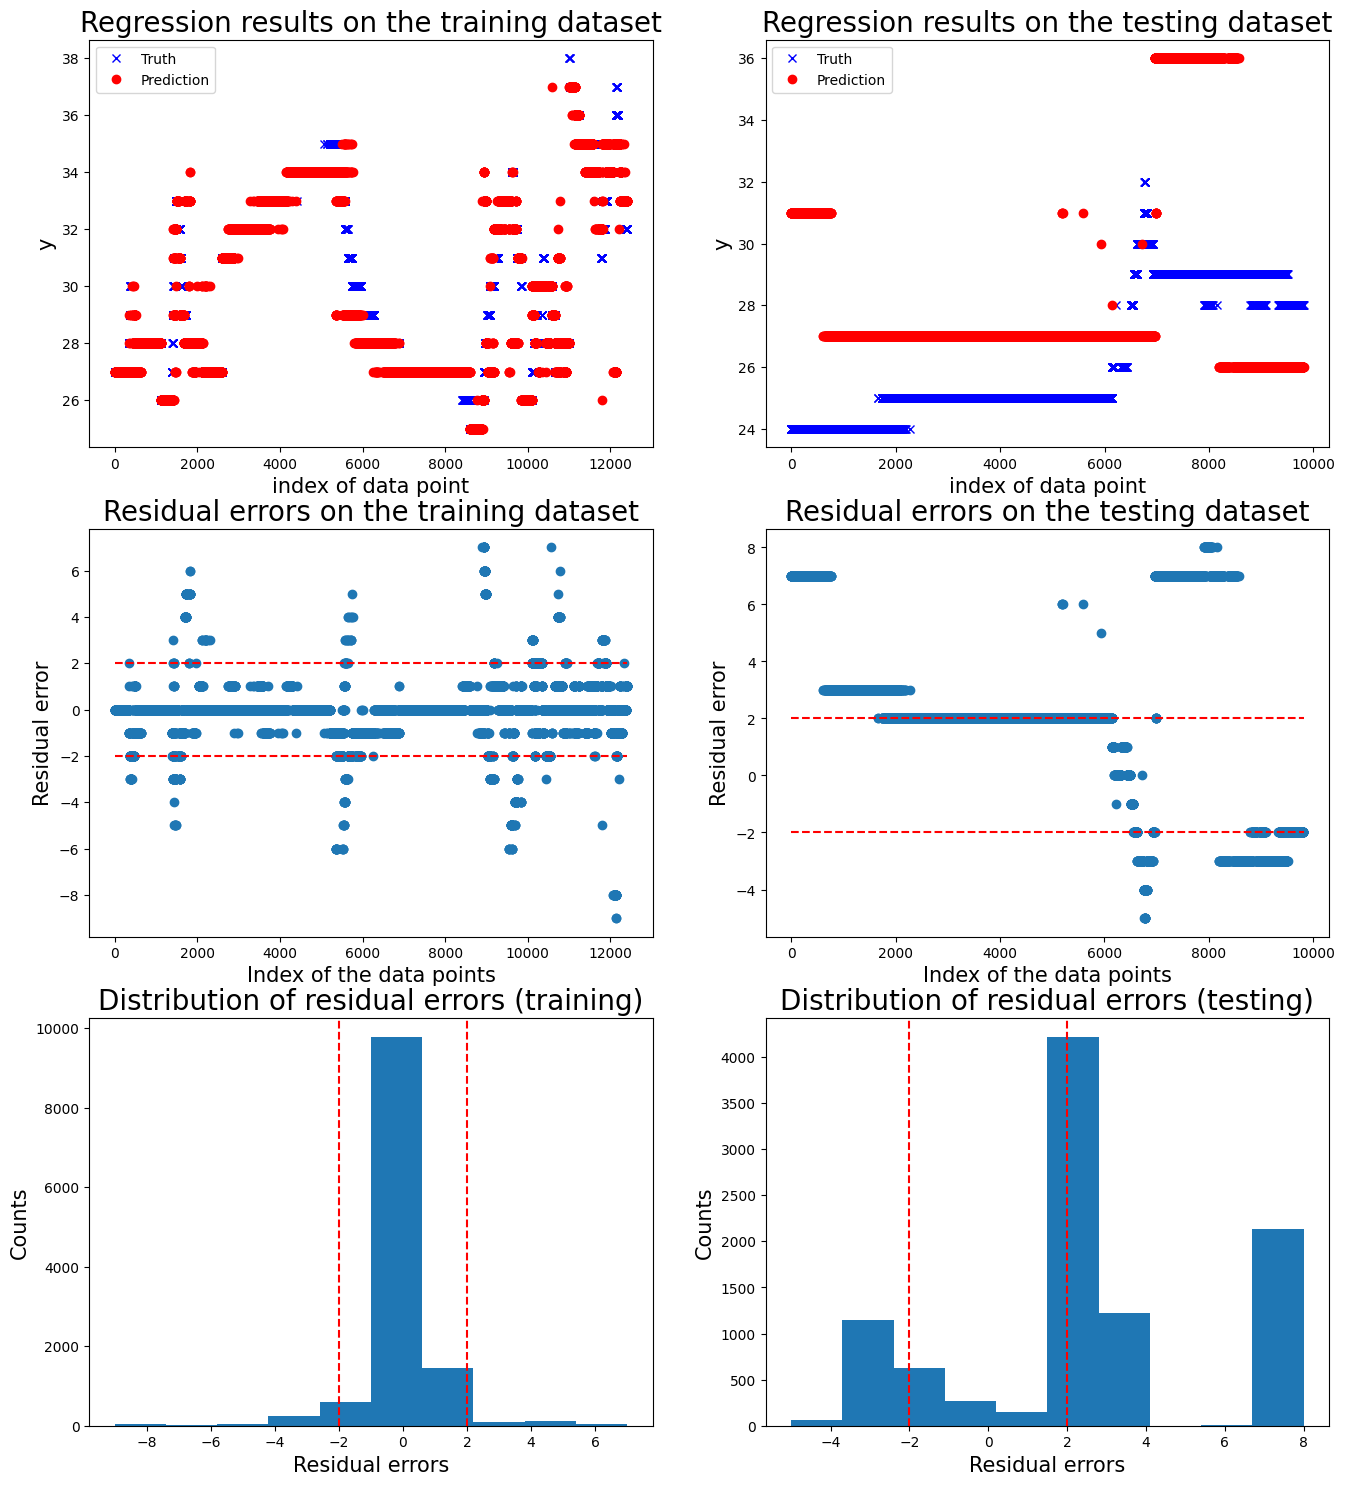

c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed i


 New run:

training performance, max error is: 8.0
training performance, mean root square error is: 1.015775290497262
training performance, residual error > 2: 4.1230273446756085%

 New run:

testing performance, max error is: 5.0
testing performance, mean root square error is: 2.058839313840366
testing performance, residual error > 2: 16.726296958855098%


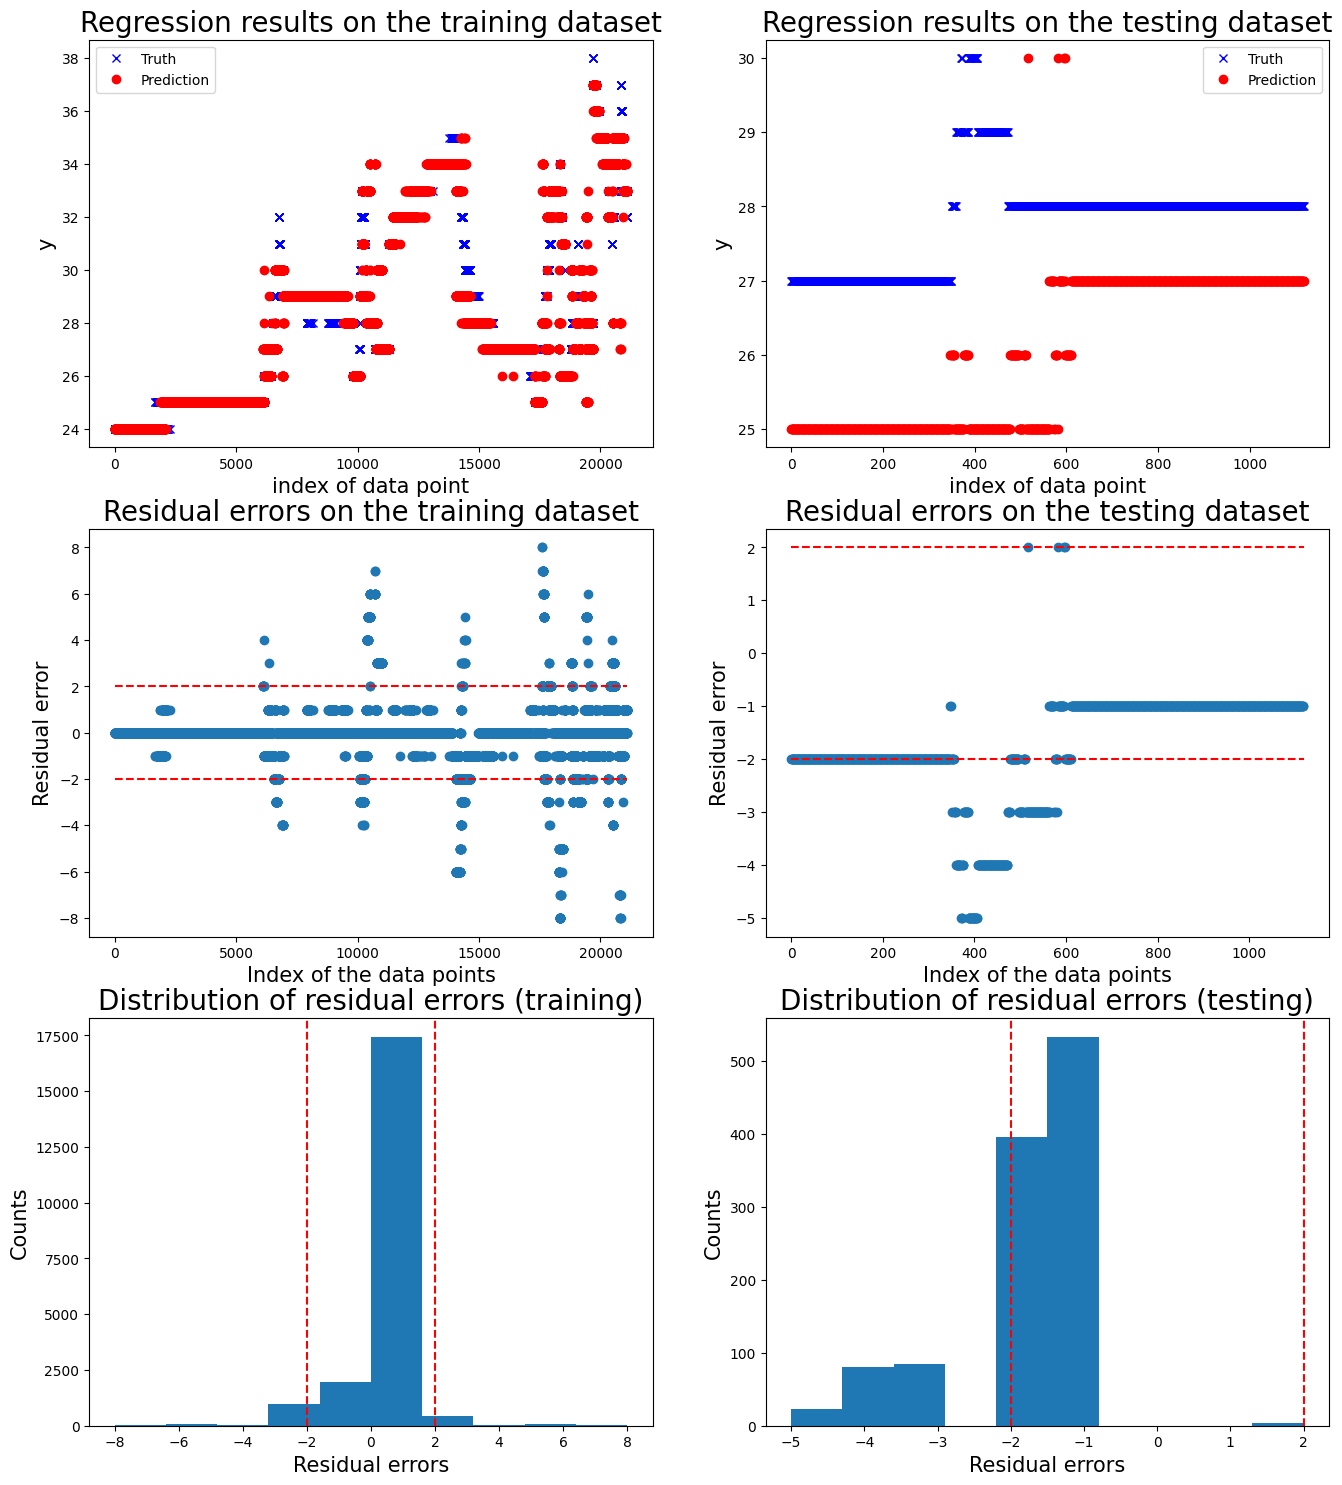

c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed i


 New run:

training performance, max error is: 5.0
training performance, mean root square error is: 0.44942991225876705
training performance, residual error > 2: 0.47456621681744027%

 New run:

testing performance, max error is: 11.0
testing performance, mean root square error is: 5.895770123362371
testing performance, residual error > 2: 59.78472460780946%


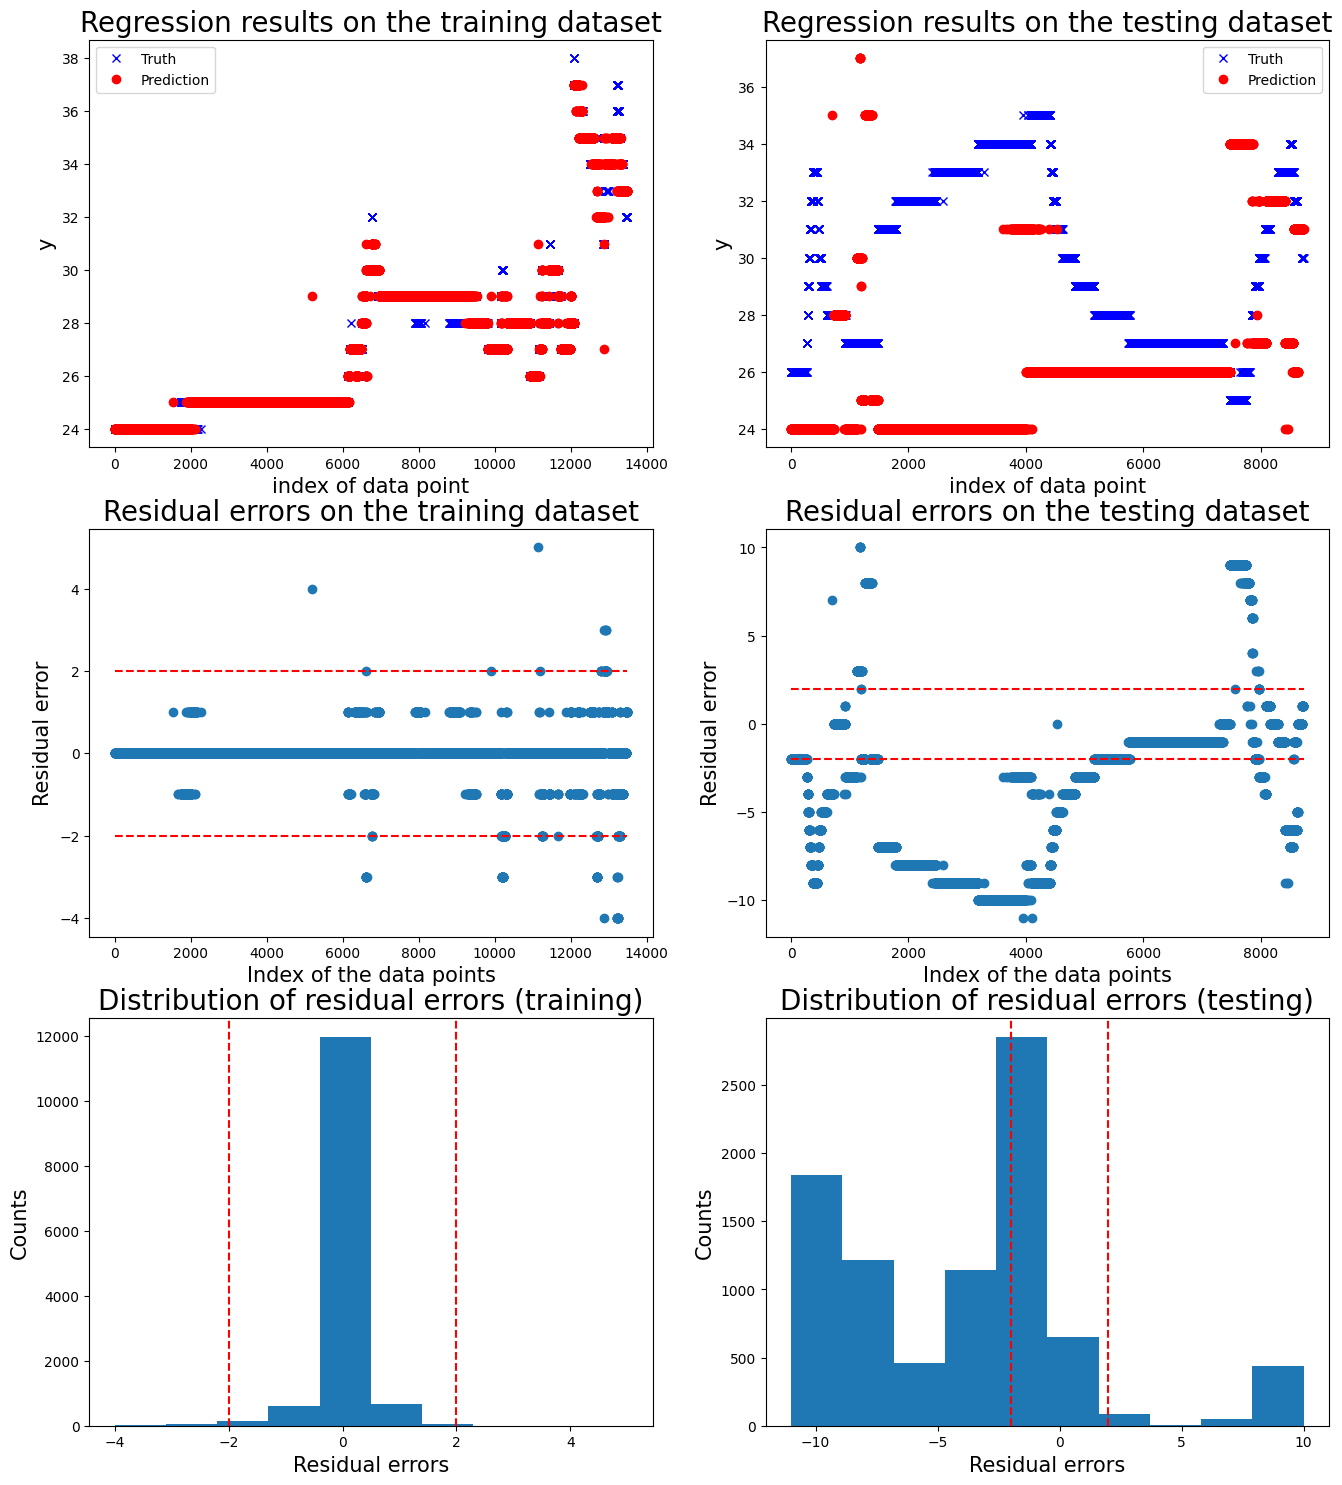

c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed i


 New run:

training performance, max error is: 9.0
training performance, mean root square error is: 1.0162582157841222
training performance, residual error > 2: 2.913845435442447%

 New run:

testing performance, max error is: 9.0
testing performance, mean root square error is: 3.274543756910327
testing performance, residual error > 2: 17.039800995024876%


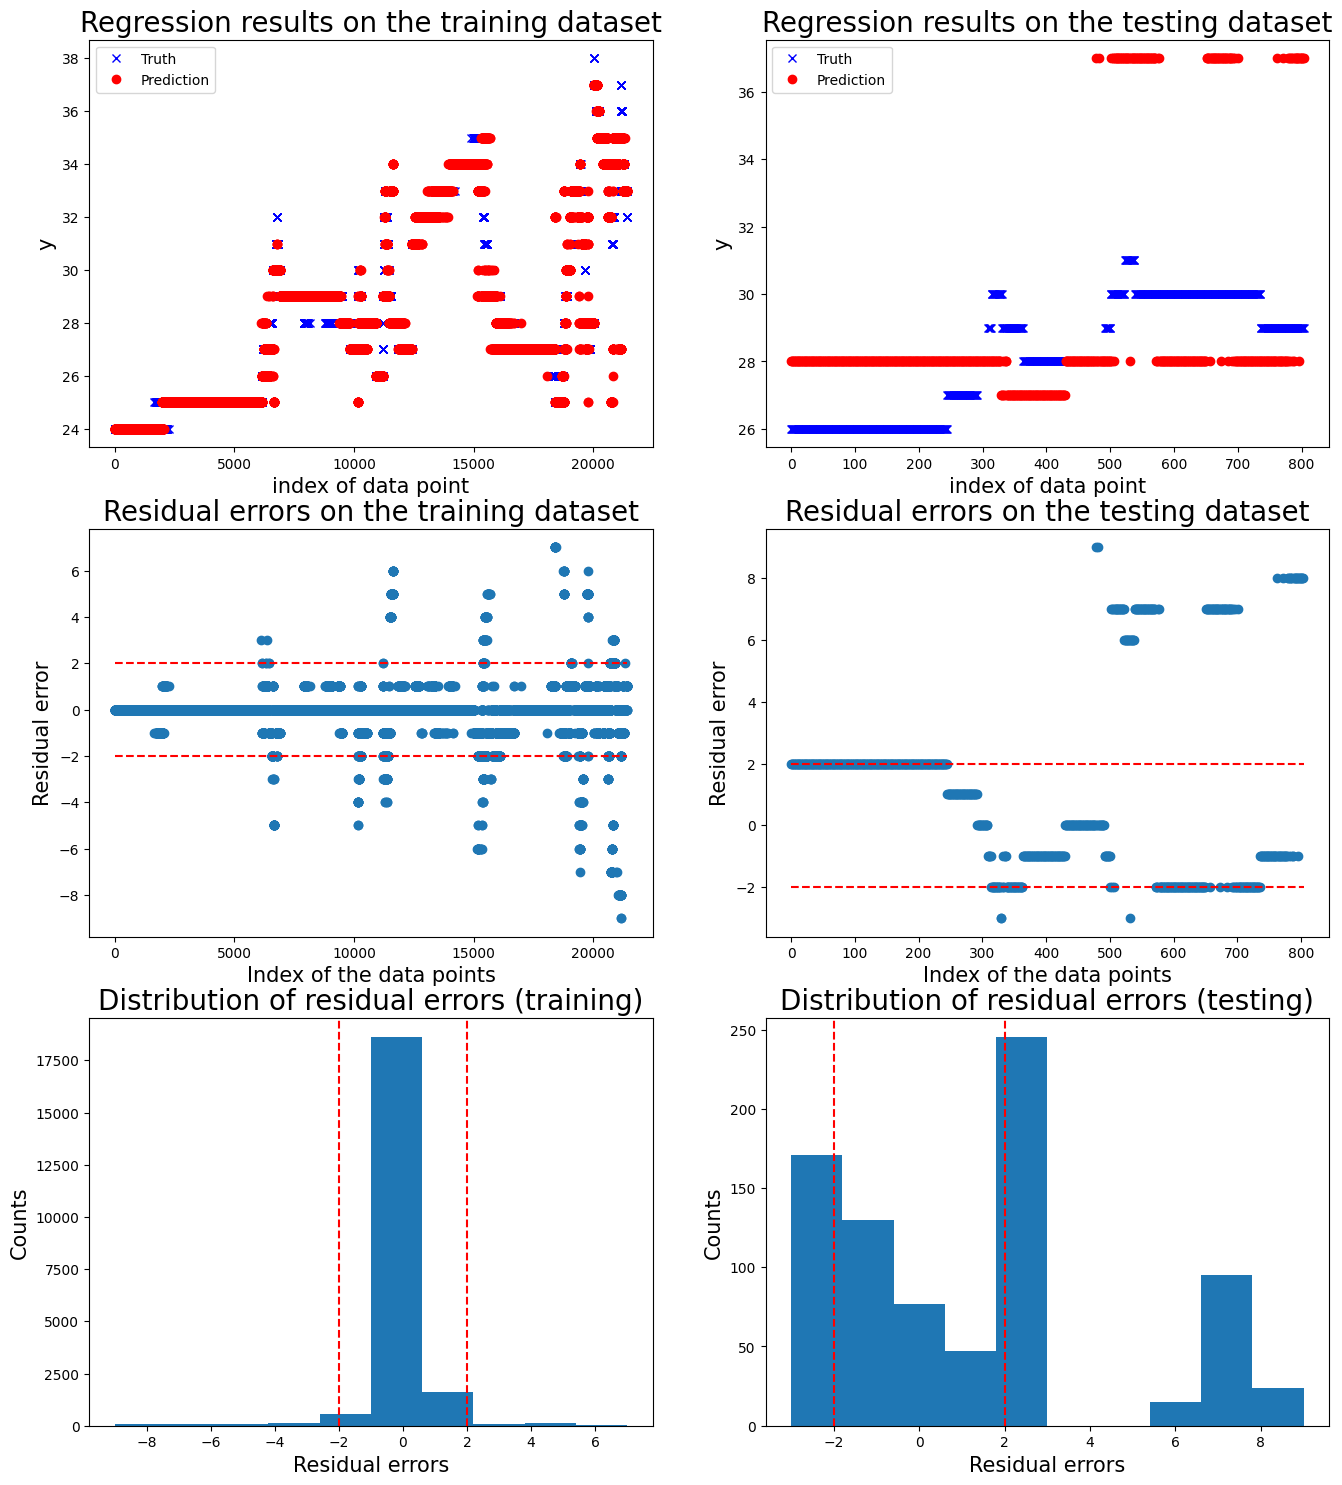

c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed i


 New run:

training performance, max error is: 8.0
training performance, mean root square error is: 0.821418783890587
training performance, residual error > 2: 2.369784032053161%

 New run:

testing performance, max error is: 12.0
testing performance, mean root square error is: 6.301875416943661
testing performance, residual error > 2: 60.69594980034228%


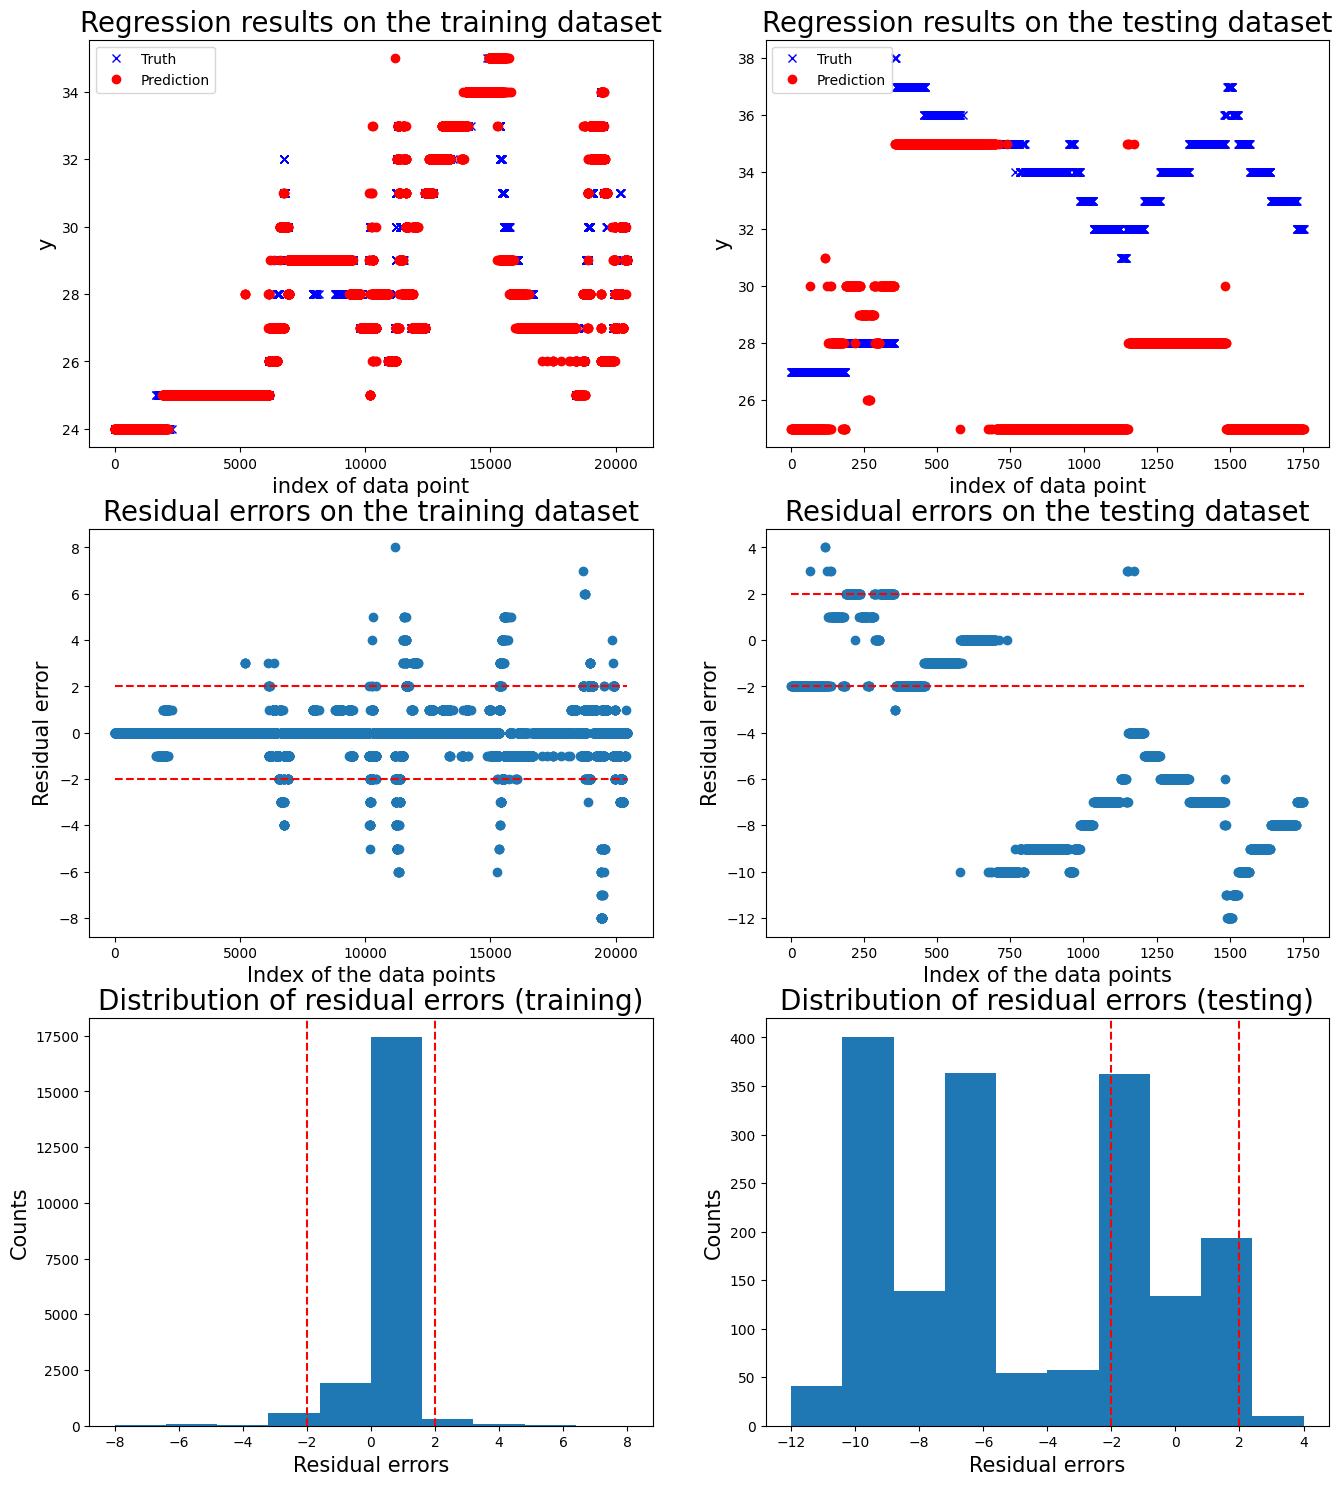

   Max error      RMSE  Exceed boundary rate
0        8.0  3.886644              0.465192
1        5.0  2.058839              0.167263
2       11.0  5.895770              0.597847
3        9.0  3.274544              0.170398
4       12.0  6.301875              0.606959


Mean performance metric and standard error:
Max error: 9.0000 +- 2.7386
RMSE: 4.2835 +- 1.7887
Exceed boundary rate: 0.4015 +- 0.2197




In [29]:
from utility import run_cv_one_motor


feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

threshold = 2
window_size = 1
sample_step = 1

df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data_smoothing, mdl=mdl_linear_regreession, 
            feature_list=feature_list_all, n_fold=5, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, mdl_type='reg')

### Define a function to run the cross validation for all the motors.

In [10]:
from utility import run_cv_one_motor


def run_all_motors(df_data, mdl, feature_list, n_fold=5, threshold=3, window_size=1, sample_step=1,
            prediction_lead_time=1, single_run_result=True, mdl_type='reg'):
    all_results = []
    # Loop over all the six motors.
    for i in range(1, 7):
        print(f'Model for predicting temperature of motor {i}:')
        # Run cross validation.
        df_perf = run_cv_one_motor(motor_idx=i, df_data=df_data, mdl=mdl, feature_list=feature_list,
                n_fold=n_fold, threshold=threshold, window_size=window_size, sample_step=sample_step,
            prediction_lead_time=prediction_lead_time, single_run_result=single_run_result, mdl_type=mdl_type)
        all_results.append(df_perf)

    return all_results

## Train a linear regression model using a 5-fold cross validation

Then, we run a 5 fold cross validation.

### Only removing outliers

In [11]:
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

threshold = 1
window_size = 1
sample_step = 1

all_results = run_all_motors(df_data=df_data, mdl=mdl_linear_regreession, feature_list=feature_list_all, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, single_run_result=False)

Model for predicting temperature of motor 1:
Model for motor 1:


c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated i

   Max error       RMSE  Exceed boundary rate
0  30.582436  14.960041              0.936500
1  38.565166   9.026156              0.976744
2  26.012939  10.704650              0.990038
3  25.766062  12.597964              1.000000
4  20.807848   3.603193              0.855676


Mean performance metric and standard error:
Max error: 28.3469 +- 6.6775
RMSE: 10.1784 +- 4.2882
Exceed boundary rate: 0.9518 +- 0.0589


Model for predicting temperature of motor 2:
Model for motor 2:


c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated i

   Max error      RMSE  Exceed boundary rate
0  10.044365  4.563991              0.812761
1  27.216599  9.148082              1.000000
2  14.459676  7.088114              0.953739
3   9.170366  5.026368              0.965174
4   7.932824  2.858879              0.916144


Mean performance metric and standard error:
Max error: 13.7648 +- 7.9120
RMSE: 5.7371 +- 2.4303
Exceed boundary rate: 0.9296 +- 0.0718


Model for predicting temperature of motor 3:
Model for motor 3:


c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated i

   Max error      RMSE  Exceed boundary rate
0  20.286556  9.276910              0.839262
1  17.766105  9.152068              0.998211
2  23.151040  7.229222              0.926371
3  14.137783  9.576229              1.000000
4  13.262231  8.428561              0.992584


Mean performance metric and standard error:
Max error: 17.7207 +- 4.1470
RMSE: 8.7326 +- 0.9403
Exceed boundary rate: 0.9513 +- 0.0697


Model for predicting temperature of motor 4:
Model for motor 4:


c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated i

   Max error       RMSE  Exceed boundary rate
0  23.476946  11.093169              0.946692
1  32.242629  10.346693              0.780859
2  22.600964  15.120810              0.926715
3  20.264427   7.849071              0.851990
4  14.885361   8.483246              0.998289


Mean performance metric and standard error:
Max error: 22.6941 +- 6.2983
RMSE: 10.5786 +- 2.8632
Exceed boundary rate: 0.9009 +- 0.0852


Model for predicting temperature of motor 5:
Model for motor 5:


c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated i

   Max error      RMSE  Exceed boundary rate
0  16.142867  7.310994              0.765569
1  15.273855  5.584714              0.987478
2  13.350284  4.326248              0.727471
3  12.851812  5.653413              0.977612
4   9.152446  5.110080              0.784940


Mean performance metric and standard error:
Max error: 13.3543 +- 2.7097
RMSE: 5.5971 +- 1.0946
Exceed boundary rate: 0.8486 +- 0.1240


Model for predicting temperature of motor 6:
Model for motor 6:


c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated i

   Max error      RMSE  Exceed boundary rate
0  14.209864  6.503249              0.818775
1  14.916205  5.523605              0.995528
2   8.129535  4.227288              0.632314
3  11.186461  5.163098              0.838308
4   9.631486  5.175137              0.877353


Mean performance metric and standard error:
Max error: 11.6147 +- 2.9111
RMSE: 5.3185 +- 0.8187
Exceed boundary rate: 0.8325 +- 0.1312




c:\Users\idris\OneDrive\Bureau\industrie4\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Use a sliding window to predict the next point

In this section, we show a demonstration of how to use a sliding window to predict the next point. We first define a window. Then, the previous points in the window will be used to predict the next point. When the window size shrink to 1, it is equial to the previous model.

### Only removing outliers

In [8]:
threshold = 1
window_size = 5
sample_step = 1
prediction_lead_time = 1 # We add the temperature measurement up to 1 point before the current time.

all_results = run_all_motors(df_data=df_data, mdl=mdl_linear_regreession, feature_list=feature_list_all, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, single_run_result=False)

Model for predicting temperature of motor 1:
Model for motor 1:
   Max error      RMSE  Exceed boundary rate
0   1.057136  0.134383              0.004286
1   1.007989  0.119191              0.000904
2   1.099128  0.169968              0.005733
3   1.061166  0.129220              0.001263
4   1.024728  0.179385              0.010913


Mean performance metric and standard error:
Max error: 1.0500 +- 0.0353
RMSE: 0.1464 +- 0.0266
Exceed boundary rate: 0.0046 +- 0.0041


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0   1.090495  0.086190              0.001429
1  15.420608  0.551664              0.006329
2   1.771407  0.138458              0.001949
3   1.069719  0.104864              0.002525
4   1.039876  0.108817              0.003446


Mean performance metric and standard error:
Max error: 4.0784 +- 6.3478
RMSE: 0.1980 +- 0.1986
Exceed boundary rate: 0.0031 +- 0.0019


Model for predicting temperature of motor 3:
Model for m

### Smoothing

In [9]:
threshold = 1
window_size = 5
sample_step = 1
prediction_lead_time = 1 # We add the temperature measurement up to 1 point before the current time.

all_results = run_all_motors(df_data=df_data_smoothing, mdl=mdl_linear_regreession, feature_list=feature_list_all, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, single_run_result=False)

Model for predicting temperature of motor 1:
Model for motor 1:
   Max error      RMSE  Exceed boundary rate
0   1.056542  0.134489              0.004592
1   1.148743  0.123654              0.001808
2   1.080344  0.172315              0.005619
3   1.068108  0.129877              0.001263
4   1.030664  0.179336              0.009765


Mean performance metric and standard error:
Max error: 1.0769 +- 0.0442
RMSE: 0.1479 +- 0.0259
Exceed boundary rate: 0.0046 +- 0.0034


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0   1.030065  0.076582              0.001531
1   1.126874  0.107132              0.002712
2   1.034086  0.123384              0.002981
3   1.035458  0.093925              0.003788
4   1.019542  0.099927              0.003446


Mean performance metric and standard error:
Max error: 1.0492 +- 0.0439
RMSE: 0.1002 +- 0.0172
Exceed boundary rate: 0.0029 +- 0.0009


Model for predicting temperature of motor 3:
Model for m